<Axes: xlabel='Date_Symptoms'>

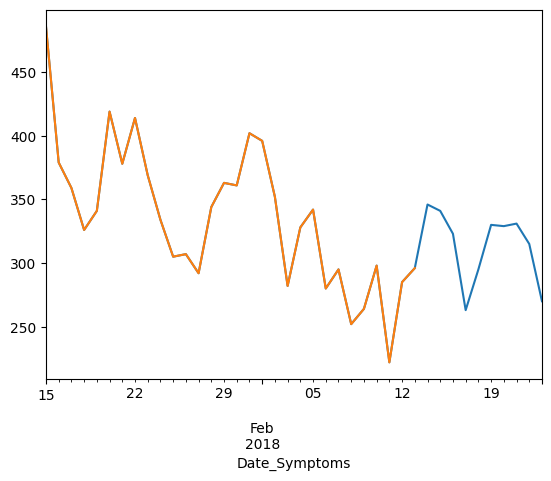

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytensor.tensor as pt

def sampler_kwargs():
    return dict(
        nuts_sampler="nutpie",
        chains=2,
        draws=300,
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"},
    )

project_dir = Path.cwd().parent
train_df = pd.read_csv(project_dir / "data" / "model" / "training_data.csv",
    parse_dates=True,
    date_format="%Y %b",
    index_col=0,
    dtype={"value": float},
)

start_index = 1800
M = 30
D = 10

y = train_df.sum(axis=1)[start_index: start_index + M + D]
y.index = pd.to_datetime(y.index)
y.index.freq = y.index.inferred_freq

y_train = y[:-D]
y.plot()
y_train.plot()

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

In [3]:
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 8998
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-darkgrid")

In [4]:
# Inputs



In [5]:
t = np.array(range(len(y_train)))
def create_fourier_features(t, n, p=365.25):
    x = 2 * np.pi * (pt.arange(n)+1) * t[:, None] / p
    return pt.concatenate((pt.cos(x), pt.sin(x)), axis = 1)






In [ ]:

with pm.Model() as model:
    t_shared = pm.MutableData("t", t)
    biweekly_fourier_shared = create_fourier_features(t_shared, n=5, p=3.5)
    weekly_fourier_shared = create_fourier_features(t_shared, n=5, p=7)


    # Trend
    b0 = pm.Normal("b0", mu=0, sigma=0.5)
    b1 = pm.Normal("b1", mu=0, sigma=0.5)
    sigma = pm.HalfNormal("sigma", sigma=0.1)
    trend = pm.Deterministic("trend", b0 + b1 * t_shared)
    
    # Fourier Seasonality
    beta_biweekly = pm.Normal("beta_biweekly", 0, 1, shape=biweekly_fourier_shared.shape[1])
    seasonality_biweekly = pm.Deterministic(
        "seasonality_biweekly", pm.math.dot(biweekly_fourier_shared, beta_biweekly)
    )

    beta_weekly = pm.Normal("beta_weekly", 0, 1, shape=weekly_fourier_shared.shape[1])
    seasonality_weekly = pm.Deterministic(
        "seasonality_weekly", pm.math.dot(weekly_fourier_shared, beta_weekly)
    )

    # AR(1) latent residuals
    phi = pm.Uniform("phi", -1, 1)
    v = pm.HalfNormal("v", 1)
    
    n_t = y_train.shape[0]
    epsilon = pm.AR("epsilon", rho=phi, sigma=v, shape=n_t)

    
    log_lam = trend + seasonality_biweekly + seasonality_weekly + epsilon
    lam = pm.Deterministic("lam", pm.math.exp(log_lam))

    y_hat = pm.Poisson("y_hat", mu=lam, observed=y_train, shape=t_shared.shape)

    idata = pm.sample(**sampler_kwargs())

    

/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/NowcastingVenv/lib/python3.12/site-packages/pymc/data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/NowcastingVenv/lib/python3.12/site-packages/pymc/distributions/timeseries.py:621: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, b1, sigma, beta_biweekly, beta_weekly, phi, v, epsilon]


Output()

In [ ]:
with model:
    #in-sample 
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True)
    
    #out-of-sample
    
    last_t = t[-1]


    # Forcast 3 years of home sales
    forcast_t = np.arange(last_t, last_t + D)
    pm.set_data({'t':forcast_t})
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True, predictions=True)



Sampling: [y]


Output()

Sampling: [beta_biweekly, beta_weekly, y]


Output()

ValueError: Shape mismatch: A.shape[0] != y.shape[0]
Apply node that caused the error: CGemv{no_inplace}(epsilon, 1.0, Join.0, beta_weekly, 1.0)
Toposort index: 4
Inputs types: [TensorType(float64, shape=(None,)), TensorType(float64, shape=()), TensorType(float64, shape=(None, 10)), TensorType(float64, shape=(10,)), TensorType(float64, shape=())]
Inputs shapes: [(30,), (), (10, 10), (10,), ()]
Inputs strides: [(8,), (), (80, 8), (8,), ()]
Inputs values: ['not shown', array(1.), 'not shown', 'not shown', array(1.)]
Outputs clients: [[Composite{exp((i0 + i1 + i2))}(ExpandDims{axis=0}.0, CGemv{inplace}.0, CGemv{no_inplace}.0)]]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [ ]:
with model:
    trace = pm.sample(return_inferencedata=True)
    post = pm.sample_posterior_predictive(trace=trace)



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, b1, sigma, beta_biweekly, beta_weekly, phi, v, epsilon]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


Output()

/var/folders/5f/9g0vtmkj22j_xbhxyrknnv140000gn/T/ipykernel_35995/4170598122.py:1: FutureWarning: extract_dataset has been deprecated, please use extract
  y_post_samples = az.extract_dataset(post, group="posterior_predictive", num_samples=100)["y"]


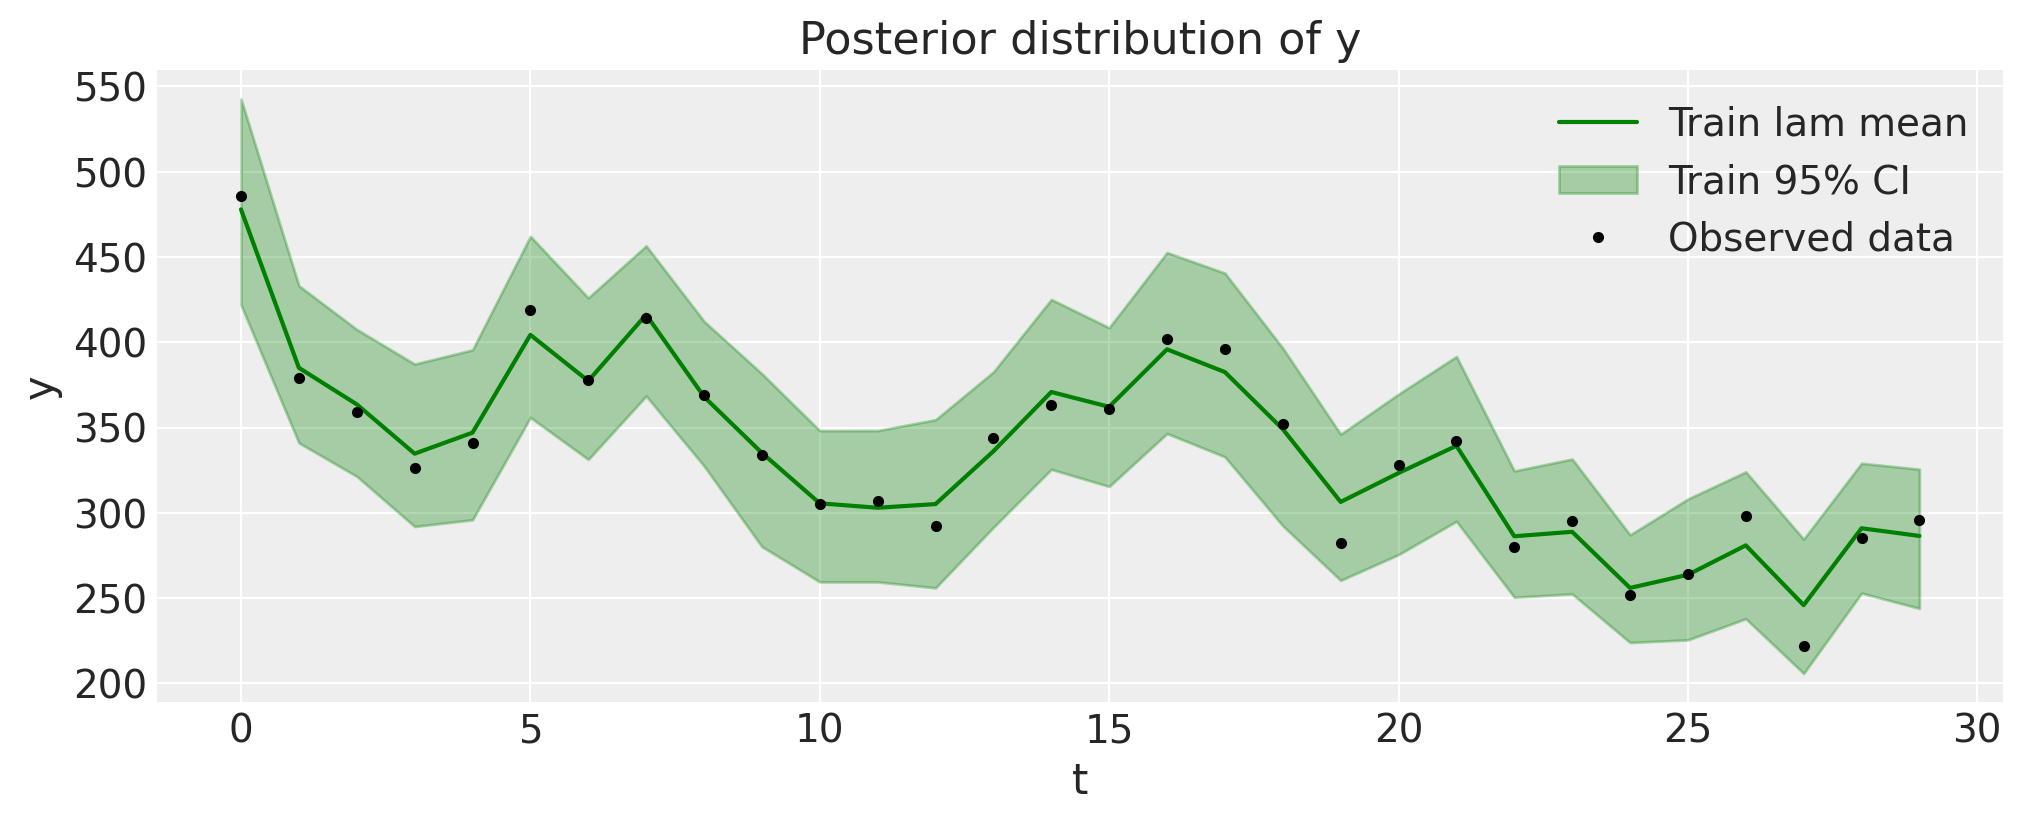

In [ ]:
y_post_samples = az.extract_dataset(post, group="posterior_predictive", num_samples=100)["y"]


mean_train = y_post_samples.mean(axis=1)
lower_train = np.percentile(y_post_samples, 2.5, axis=1)
upper_train = np.percentile(y_post_samples, 97.5, axis=1)


# plot the results
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

# Plot CI for training data
ax.plot(t, mean_train, color='green', label="Train lam mean")
ax.fill_between(t, lower_train, upper_train, color='green', alpha=0.3, label='Train 95% CI')

ax.plot(t, y_train, "ok", ms=3, label="Observed data")

# axis labels and title
plt.xlabel("t")
plt.ylabel("y")
plt.title("Posterior distribution of y")
plt.legend()

D day ahead forecast